In [ ]:
%%capture
!pip install super-gradients
!pip install --upgrade pillow
!pip install --upgrade torchvision
!pip install super-gradients
!pip install torch

In [ ]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2024-05-23 21:37:19] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-05-23 21:37:25] INFO - utils.py - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-05-23 21:37:25] INFO - utils.py - NumExpr defaulting to 8 threads.
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: torchmetrics required but not found
[2024-05-23 21:37:28] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2024-05-23 21:37:28] WARNING - env_san

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Colab Notebooks/

Mounted at /content/drive


In [ ]:
class config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = 'race_number'

    DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets'
    TRAIN_IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/train/images'
    TRAIN_LABELS_DIR = '/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/train/labels'
    VAL_IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/valid/images'
    VAL_LABELS_DIR = '/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/valid/labels'


    CLASSES = ['Parking']
    NUM_CLASSES = len(CLASSES)




    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }


    MODEL_NAME = 'yolo_nas_l'
    PRETRAINED_WEIGHTS = 'coco'

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME,
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)




[2024-05-23 21:42:32] WARNING - yolo_format_detection.py - 3 images are note associated to any label file
[2024-05-23 21:42:32] WARNING - yolo_format_detection.py - As a consequence, 51/54 images and 51/51 label files will be used.
[2024-05-23 21:42:32] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 51/51 [01:54<00:00,  2.25s/it]
[2024-05-23 21:44:28] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

Indexing dataset annotations: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


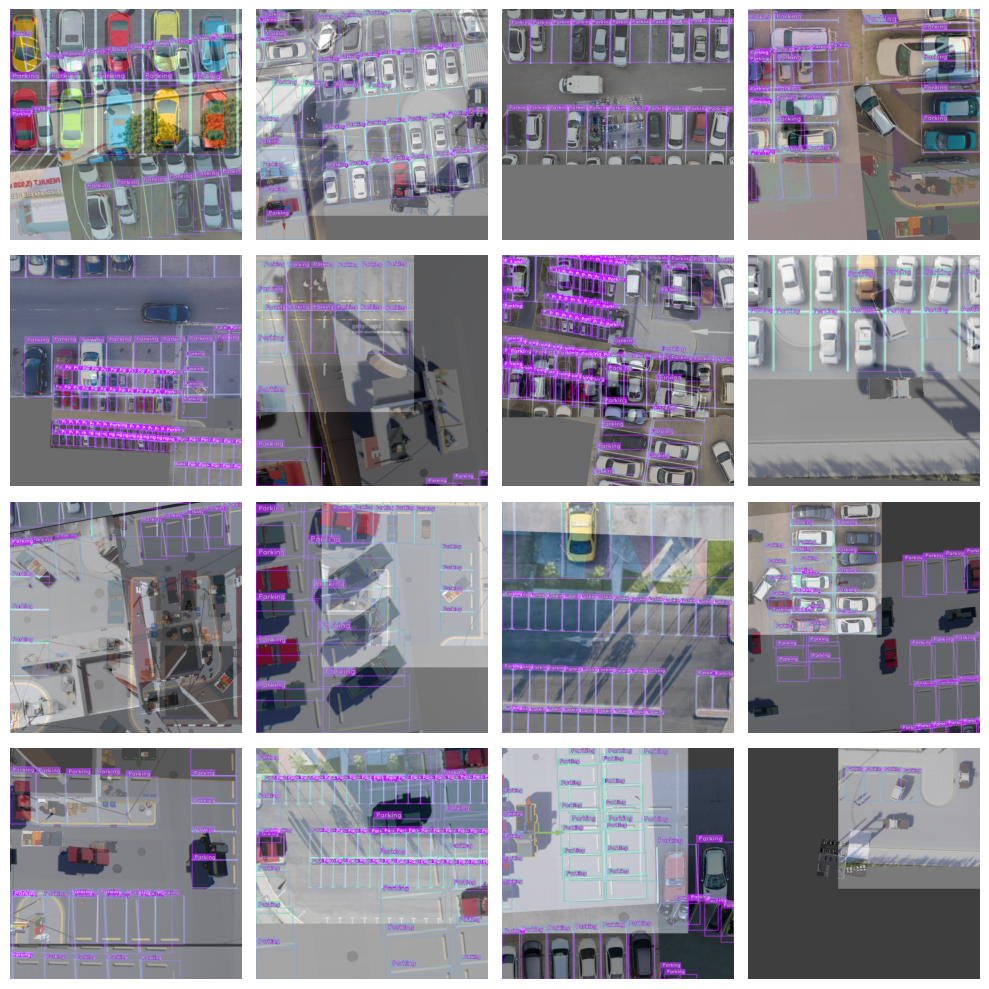

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-05-23 21:44:55] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-23 21:44:55] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:17<00:00, 15.3MB/s]
[2024-05-23 21:45:14] INFO - checkpoin

In [ ]:
from keras.callbacks import EarlyStopping

train_params = {
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 35,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50',
    "callbacks": [
        EarlyStopping(
            monitor="mAP@0.50",
            patience=5,
            verbose=True,
            mode="max",
            restore_best_weights=True
        )
    ]
}


/usr/local/lib/python3.10/dist-packages/super_gradients/training/losses/ppyolo_loss.py:669: DeprecationWarning: A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs
  warnings.warn(


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-05-23 22:07:35] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240523_220735_495739`
[2024-05-23 22:07:35] INFO - sg_trainer.py - Checkpoints directory: checkpoints/race_number/RUN_20240523_220735_495739
[2024-05-23 22:07:35] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/race_number/RUN_20240523_220735_495739/console_May23_22_07_35.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9191
│   ├── Ppyoloeloss/loss_iou = 0.5445
│   ├── Ppyoloeloss/loss_dfl = 0.5996
│   └── Ppyoloeloss/loss = 2.0632
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.7189
    ├── Ppyoloeloss/loss_iou = 0.3451
    ├── Ppyoloeloss/loss_dfl = 0.5008
    ├── Ppyoloeloss/loss = 4.5648
    ├── Precision@0.50 = 0.0916
    ├── Recall@0.50 = 0.9759
    ├── Map@0.50 = 0.8499
    ├── F1@0.50 = 0.1675
    └── Best_score_threshold = 0.96



Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9325
│   │   ├── Epoch N-1      = 0.9191 (↗ 0.0134)
│   │   └── Best until now = 0.9191 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.5334
│   │   ├── Epoch N-1      = 0.5445 (↘ -0.0112)
│   │   └── Best until now = 0.5445 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.561
│   │   ├── Epoch N-1      = 0.5996 (↘ -0.0386)
│   │   └── Best until now = 0.5996 (↘ -0.0386)
│   └── Ppyoloeloss/loss = 2.0269
│       ├── Epoch N-1      = 2.0632 (↘ -0.0363)
│       └── Best until now = 2.0632 (↘ -0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2627
    │   ├── Epoch N-1      = 3.7189 (↘ -1.4562)
    │   └── Best until now = 3.7189 (↘ -1.4562)
    ├── Ppyoloeloss/loss_iou = 0.2937
    │   ├── Epoch N-1      = 0.3451 (↘ -0.0514)
    │   └── Best until now = 0.3451 (↘ -0.0514)
    ├── Ppyoloeloss/loss_dfl = 0.4506
    │   ├── Epoch N-1      = 0.5008 (↘ -0.0502)
    │   └── Best until now = 0.5008 (↘ -0.0502)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8161
│   │   ├── Epoch N-1      = 0.9325 (↘ -0.1164)
│   │   └── Best until now = 0.9191 (↘ -0.103)
│   ├── Ppyoloeloss/loss_iou = 0.4973
│   │   ├── Epoch N-1      = 0.5334 (↘ -0.036)
│   │   └── Best until now = 0.5334 (↘ -0.036)
│   ├── Ppyoloeloss/loss_dfl = 0.5284
│   │   ├── Epoch N-1      = 0.561  (↘ -0.0326)
│   │   └── Best until now = 0.561  (↘ -0.0326)
│   └── Ppyoloeloss/loss = 1.8418
│       ├── Epoch N-1      = 2.0269 (↘ -0.1851)
│       └── Best until now = 2.0269 (↘ -0.1851)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.821
    │   ├── Epoch N-1      = 2.2627 (↘ -1.4417)
    │   └── Best until now = 2.2627 (↘ -1.4417)
    ├── Ppyoloeloss/loss_iou = 0.3654
    │   ├── Epoch N-1      = 0.2937 (↗ 0.0717)
    │   └── Best until now = 0.2937 (↗ 0.0717)
    ├── Ppyoloeloss/loss_dfl = 0.5293
    │   ├── Epoch N-1      = 0.4506 (↗ 0.0788)
    │   └── Best until now = 0.4506 (↗ 0.0788)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7798
│   │   ├── Epoch N-1      = 0.8161 (↘ -0.0363)
│   │   └── Best until now = 0.8161 (↘ -0.0363)
│   ├── Ppyoloeloss/loss_iou = 0.4535
│   │   ├── Epoch N-1      = 0.4973 (↘ -0.0439)
│   │   └── Best until now = 0.4973 (↘ -0.0439)
│   ├── Ppyoloeloss/loss_dfl = 0.5036
│   │   ├── Epoch N-1      = 0.5284 (↘ -0.0247)
│   │   └── Best until now = 0.5284 (↘ -0.0247)
│   └── Ppyoloeloss/loss = 1.7369
│       ├── Epoch N-1      = 1.8418 (↘ -0.1049)
│       └── Best until now = 1.8418 (↘ -0.1049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8828
    │   ├── Epoch N-1      = 0.821  (↗ 0.0618)
    │   └── Best until now = 0.821  (↗ 0.0618)
    ├── Ppyoloeloss/loss_iou = 0.4427
    │   ├── Epoch N-1      = 0.3654 (↗ 0.0773)
    │   └── Best until now = 0.2937 (↗ 0.149)
    ├── Ppyoloeloss/loss_dfl = 0.5666
    │   ├── Epoch N-1      = 0.5293 (↗ 0.0373)
    │   └── Best until now = 0.4506 (↗ 0.116)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.769
│   │   ├── Epoch N-1      = 0.7798 (↘ -0.0108)
│   │   └── Best until now = 0.7798 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.4509
│   │   ├── Epoch N-1      = 0.4535 (↘ -0.0026)
│   │   └── Best until now = 0.4535 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.4969
│   │   ├── Epoch N-1      = 0.5036 (↘ -0.0068)
│   │   └── Best until now = 0.5036 (↘ -0.0068)
│   └── Ppyoloeloss/loss = 1.7167
│       ├── Epoch N-1      = 1.7369 (↘ -0.0202)
│       └── Best until now = 1.7369 (↘ -0.0202)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9647
    │   ├── Epoch N-1      = 0.8828 (↗ 0.0819)
    │   └── Best until now = 0.821  (↗ 0.1437)
    ├── Ppyoloeloss/loss_iou = 0.3656
    │   ├── Epoch N-1      = 0.4427 (↘ -0.077)
    │   └── Best until now = 0.2937 (↗ 0.072)
    ├── Ppyoloeloss/loss_dfl = 0.5076
    │   ├── Epoch N-1      = 0.5666 (↘ -0.059)
    │   └── Best until now = 0.4506 (↗ 0.057)
    ├── Ppyoloeloss/loss = 1.83

Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8655
│   │   ├── Epoch N-1      = 0.769  (↗ 0.0965)
│   │   └── Best until now = 0.769  (↗ 0.0965)
│   ├── Ppyoloeloss/loss_iou = 0.4586
│   │   ├── Epoch N-1      = 0.4509 (↗ 0.0077)
│   │   └── Best until now = 0.4509 (↗ 0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.4719
│   │   ├── Epoch N-1      = 0.4969 (↘ -0.025)
│   │   └── Best until now = 0.4969 (↘ -0.025)
│   └── Ppyoloeloss/loss = 1.796
│       ├── Epoch N-1      = 1.7167 (↗ 0.0792)
│       └── Best until now = 1.7167 (↗ 0.0792)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7874
    │   ├── Epoch N-1      = 0.9647 (↘ -0.1772)
    │   └── Best until now = 0.821  (↘ -0.0335)
    ├── Ppyoloeloss/loss_iou = 0.2898
    │   ├── Epoch N-1      = 0.3656 (↘ -0.0758)
    │   └── Best until now = 0.2937 (↘ -0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.418
    │   ├── Epoch N-1      = 0.5076 (↘ -0.0897)
    │   └── Best until now = 0.4506 (↘ -0.0326)
    ├── Ppyoloeloss/loss = 1.495

Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.758
│   │   ├── Epoch N-1      = 0.8655 (↘ -0.1075)
│   │   └── Best until now = 0.769  (↘ -0.011)
│   ├── Ppyoloeloss/loss_iou = 0.4096
│   │   ├── Epoch N-1      = 0.4586 (↘ -0.0489)
│   │   └── Best until now = 0.4509 (↘ -0.0412)
│   ├── Ppyoloeloss/loss_dfl = 0.466
│   │   ├── Epoch N-1      = 0.4719 (↘ -0.0059)
│   │   └── Best until now = 0.4719 (↘ -0.0059)
│   └── Ppyoloeloss/loss = 1.6337
│       ├── Epoch N-1      = 1.796  (↘ -0.1623)
│       └── Best until now = 1.7167 (↘ -0.0831)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9972
    │   ├── Epoch N-1      = 0.7874 (↗ 0.2098)
    │   └── Best until now = 0.7874 (↗ 0.2098)
    ├── Ppyoloeloss/loss_iou = 0.3789
    │   ├── Epoch N-1      = 0.2898 (↗ 0.089)
    │   └── Best until now = 0.2898 (↗ 0.089)
    ├── Ppyoloeloss/loss_dfl = 0.4873
    │   ├── Epoch N-1      = 0.418  (↗ 0.0693)
    │   └── Best until now = 0.418  (↗ 0.0693)
    ├── Ppyoloeloss/loss = 1.8634

Validating epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
[2024-05-23 22:09:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:09:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8850538730621338


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7649
│   │   ├── Epoch N-1      = 0.758  (↗ 0.0069)
│   │   └── Best until now = 0.758  (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.4179
│   │   ├── Epoch N-1      = 0.4096 (↗ 0.0083)
│   │   └── Best until now = 0.4096 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.4624
│   │   ├── Epoch N-1      = 0.466  (↘ -0.0036)
│   │   └── Best until now = 0.466  (↘ -0.0036)
│   └── Ppyoloeloss/loss = 1.6453
│       ├── Epoch N-1      = 1.6337 (↗ 0.0117)
│       └── Best until now = 1.6337 (↗ 0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8607
    │   ├── Epoch N-1      = 0.9972 (↘ -0.1366)
    │   └── Best until now = 0.7874 (↗ 0.0732)
    ├── Ppyoloeloss/loss_iou = 0.2911
    │   ├── Epoch N-1      = 0.3789 (↘ -0.0878)
    │   └── Best until now = 0.2898 (↗ 0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.4077
    │   ├── Epoch N-1      = 0.4873 (↘ -0.0796)
    │   └── Best until now = 0.418  (↘ -0.0103)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7303
│   │   ├── Epoch N-1      = 0.7649 (↘ -0.0346)
│   │   └── Best until now = 0.758  (↘ -0.0277)
│   ├── Ppyoloeloss/loss_iou = 0.4022
│   │   ├── Epoch N-1      = 0.4179 (↘ -0.0157)
│   │   └── Best until now = 0.4096 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.4392
│   │   ├── Epoch N-1      = 0.4624 (↘ -0.0232)
│   │   └── Best until now = 0.4624 (↘ -0.0232)
│   └── Ppyoloeloss/loss = 1.5717
│       ├── Epoch N-1      = 1.6453 (↘ -0.0736)
│       └── Best until now = 1.6337 (↘ -0.0619)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8993
    │   ├── Epoch N-1      = 0.8607 (↗ 0.0387)
    │   └── Best until now = 0.7874 (↗ 0.1119)
    ├── Ppyoloeloss/loss_iou = 0.3735
    │   ├── Epoch N-1      = 0.2911 (↗ 0.0824)
    │   └── Best until now = 0.2898 (↗ 0.0836)
    ├── Ppyoloeloss/loss_dfl = 0.5262
    │   ├── Epoch N-1      = 0.4077 (↗ 0.1185)
    │   └── Best until now = 0.4077 (↗ 0.1185)
    ├── Ppyoloeloss/loss = 1

Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7599
│   │   ├── Epoch N-1      = 0.7303 (↗ 0.0296)
│   │   └── Best until now = 0.7303 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_iou = 0.4132
│   │   ├── Epoch N-1      = 0.4022 (↗ 0.011)
│   │   └── Best until now = 0.4022 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.46
│   │   ├── Epoch N-1      = 0.4392 (↗ 0.0208)
│   │   └── Best until now = 0.4392 (↗ 0.0208)
│   └── Ppyoloeloss/loss = 1.6331
│       ├── Epoch N-1      = 1.5717 (↗ 0.0614)
│       └── Best until now = 1.5717 (↗ 0.0614)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6875
    │   ├── Epoch N-1      = 0.8993 (↘ -0.2119)
    │   └── Best until now = 0.7874 (↘ -0.1)
    ├── Ppyoloeloss/loss_iou = 0.28
    │   ├── Epoch N-1      = 0.3735 (↘ -0.0935)
    │   └── Best until now = 0.2898 (↘ -0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.428
    │   ├── Epoch N-1      = 0.5262 (↘ -0.0981)
    │   └── Best until now = 0.4077 (↗ 0.0203)
    ├── Ppyoloeloss/loss = 1.3955
    │  

Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7671
│   │   ├── Epoch N-1      = 0.7599 (↗ 0.0072)
│   │   └── Best until now = 0.7303 (↗ 0.0368)
│   ├── Ppyoloeloss/loss_iou = 0.4172
│   │   ├── Epoch N-1      = 0.4132 (↗ 0.004)
│   │   └── Best until now = 0.4022 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.4589
│   │   ├── Epoch N-1      = 0.46   (↘ -0.0011)
│   │   └── Best until now = 0.4392 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 1.6432
│       ├── Epoch N-1      = 1.6331 (↗ 0.0101)
│       └── Best until now = 1.5717 (↗ 0.0715)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.766
    │   ├── Epoch N-1      = 0.6875 (↗ 2.0785)
    │   └── Best until now = 0.6875 (↗ 2.0785)
    ├── Ppyoloeloss/loss_iou = 2.2992
    │   ├── Epoch N-1      = 0.28   (↗ 2.0193)
    │   └── Best until now = 0.28   (↗ 2.0193)
    ├── Ppyoloeloss/loss_dfl = 1.916
    │   ├── Epoch N-1      = 0.428  (↗ 1.488)
    │   └── Best until now = 0.4077 (↗ 1.5083)
    ├── Ppyoloeloss/loss = 6.9812
    │

Validating epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[2024-05-23 22:10:55] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:10:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9474318623542786


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7443
│   │   ├── Epoch N-1      = 0.7671 (↘ -0.0228)
│   │   └── Best until now = 0.7303 (↗ 0.014)
│   ├── Ppyoloeloss/loss_iou = 0.4076
│   │   ├── Epoch N-1      = 0.4172 (↘ -0.0096)
│   │   └── Best until now = 0.4022 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.463
│   │   ├── Epoch N-1      = 0.4589 (↗ 0.0041)
│   │   └── Best until now = 0.4392 (↗ 0.0238)
│   └── Ppyoloeloss/loss = 1.6149
│       ├── Epoch N-1      = 1.6432 (↘ -0.0283)
│       └── Best until now = 1.5717 (↗ 0.0432)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6919
    │   ├── Epoch N-1      = 2.766  (↘ -2.0741)
    │   └── Best until now = 0.6875 (↗ 0.0044)
    ├── Ppyoloeloss/loss_iou = 0.2404
    │   ├── Epoch N-1      = 2.2992 (↘ -2.0589)
    │   └── Best until now = 0.28   (↘ -0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.3551
    │   ├── Epoch N-1      = 1.916  (↘ -1.5609)
    │   └── Best until now = 0.4077 (↘ -0.0526)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7211
│   │   ├── Epoch N-1      = 0.7443 (↘ -0.0232)
│   │   └── Best until now = 0.7303 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.383
│   │   ├── Epoch N-1      = 0.4076 (↘ -0.0245)
│   │   └── Best until now = 0.4022 (↘ -0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.419
│   │   ├── Epoch N-1      = 0.463  (↘ -0.044)
│   │   └── Best until now = 0.4392 (↘ -0.0202)
│   └── Ppyoloeloss/loss = 1.5232
│       ├── Epoch N-1      = 1.6149 (↘ -0.0917)
│       └── Best until now = 1.5717 (↘ -0.0486)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8205
    │   ├── Epoch N-1      = 0.6919 (↗ 0.1286)
    │   └── Best until now = 0.6875 (↗ 0.133)
    ├── Ppyoloeloss/loss_iou = 0.3027
    │   ├── Epoch N-1      = 0.2404 (↗ 0.0623)
    │   └── Best until now = 0.2404 (↗ 0.0623)
    ├── Ppyoloeloss/loss_dfl = 0.4313
    │   ├── Epoch N-1      = 0.3551 (↗ 0.0762)
    │   └── Best until now = 0.3551 (↗ 0.0762)
    ├── Ppyoloeloss/loss = 1.55

Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7155
│   │   ├── Epoch N-1      = 0.7211 (↘ -0.0056)
│   │   └── Best until now = 0.7211 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.3699
│   │   ├── Epoch N-1      = 0.383  (↘ -0.0131)
│   │   └── Best until now = 0.383  (↘ -0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.4336
│   │   ├── Epoch N-1      = 0.419  (↗ 0.0146)
│   │   └── Best until now = 0.419  (↗ 0.0146)
│   └── Ppyoloeloss/loss = 1.519
│       ├── Epoch N-1      = 1.5232 (↘ -0.0041)
│       └── Best until now = 1.5232 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.722
    │   ├── Epoch N-1      = 0.8205 (↘ -0.0985)
    │   └── Best until now = 0.6875 (↗ 0.0345)
    ├── Ppyoloeloss/loss_iou = 0.2528
    │   ├── Epoch N-1      = 0.3027 (↘ -0.0499)
    │   └── Best until now = 0.2404 (↗ 0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.3619
    │   ├── Epoch N-1      = 0.4313 (↘ -0.0694)
    │   └── Best until now = 0.3551 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 1

Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7041
│   │   ├── Epoch N-1      = 0.7155 (↘ -0.0114)
│   │   └── Best until now = 0.7155 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.385
│   │   ├── Epoch N-1      = 0.3699 (↗ 0.0151)
│   │   └── Best until now = 0.3699 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.4347
│   │   ├── Epoch N-1      = 0.4336 (↗ 0.0011)
│   │   └── Best until now = 0.419  (↗ 0.0157)
│   └── Ppyoloeloss/loss = 1.5238
│       ├── Epoch N-1      = 1.519  (↗ 0.0048)
│       └── Best until now = 1.519  (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7944
    │   ├── Epoch N-1      = 0.722  (↗ 0.0724)
    │   └── Best until now = 0.6875 (↗ 0.1069)
    ├── Ppyoloeloss/loss_iou = 0.2766
    │   ├── Epoch N-1      = 0.2528 (↗ 0.0238)
    │   └── Best until now = 0.2404 (↗ 0.0362)
    ├── Ppyoloeloss/loss_dfl = 0.3907
    │   ├── Epoch N-1      = 0.3619 (↗ 0.0289)
    │   └── Best until now = 0.3551 (↗ 0.0356)
    ├── Ppyoloeloss/loss = 1.4617


Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
[2024-05-23 22:12:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:12:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9582529067993164


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7061
│   │   ├── Epoch N-1      = 0.7041 (↗ 0.002)
│   │   └── Best until now = 0.7041 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.3783
│   │   ├── Epoch N-1      = 0.385  (↘ -0.0067)
│   │   └── Best until now = 0.3699 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.4408
│   │   ├── Epoch N-1      = 0.4347 (↗ 0.0061)
│   │   └── Best until now = 0.419  (↗ 0.0217)
│   └── Ppyoloeloss/loss = 1.5252
│       ├── Epoch N-1      = 1.5238 (↗ 0.0014)
│       └── Best until now = 1.519  (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6759
    │   ├── Epoch N-1      = 0.7944 (↘ -0.1185)
    │   └── Best until now = 0.6875 (↘ -0.0116)
    ├── Ppyoloeloss/loss_iou = 0.2622
    │   ├── Epoch N-1      = 0.2766 (↘ -0.0143)
    │   └── Best until now = 0.2404 (↗ 0.0219)
    ├── Ppyoloeloss/loss_dfl = 0.3848
    │   ├── Epoch N-1      = 0.3907 (↘ -0.0059)
    │   └── Best until now = 0.3551 (↗ 0.0297)
    ├── Ppyoloeloss/loss = 1.322

Validating epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[2024-05-23 22:12:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:12:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.959516704082489


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6906
│   │   ├── Epoch N-1      = 0.7061 (↘ -0.0155)
│   │   └── Best until now = 0.7041 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.3631
│   │   ├── Epoch N-1      = 0.3783 (↘ -0.0153)
│   │   └── Best until now = 0.3699 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.4179
│   │   ├── Epoch N-1      = 0.4408 (↘ -0.0228)
│   │   └── Best until now = 0.419  (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4716
│       ├── Epoch N-1      = 1.5252 (↘ -0.0536)
│       └── Best until now = 1.519  (↘ -0.0474)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6969
    │   ├── Epoch N-1      = 0.6759 (↗ 0.021)
    │   └── Best until now = 0.6759 (↗ 0.021)
    ├── Ppyoloeloss/loss_iou = 0.2974
    │   ├── Epoch N-1      = 0.2622 (↗ 0.0352)
    │   └── Best until now = 0.2404 (↗ 0.0571)
    ├── Ppyoloeloss/loss_dfl = 0.4143
    │   ├── Epoch N-1      = 0.3848 (↗ 0.0295)
    │   └── Best until now = 0.3551 (↗ 0.0592)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7077
│   │   ├── Epoch N-1      = 0.6906 (↗ 0.0172)
│   │   └── Best until now = 0.6906 (↗ 0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.3531
│   │   ├── Epoch N-1      = 0.3631 (↘ -0.01)
│   │   └── Best until now = 0.3631 (↘ -0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.4138
│   │   ├── Epoch N-1      = 0.4179 (↘ -0.0041)
│   │   └── Best until now = 0.4179 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 1.4746
│       ├── Epoch N-1      = 1.4716 (↗ 0.0031)
│       └── Best until now = 1.4716 (↗ 0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6677
    │   ├── Epoch N-1      = 0.6969 (↘ -0.0292)
    │   └── Best until now = 0.6759 (↘ -0.0082)
    ├── Ppyoloeloss/loss_iou = 0.2312
    │   ├── Epoch N-1      = 0.2974 (↘ -0.0663)
    │   └── Best until now = 0.2404 (↘ -0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.3907
    │   ├── Epoch N-1      = 0.4143 (↘ -0.0236)
    │   └── Best until now = 0.3551 (↗ 0.0356)
    ├── Ppyoloeloss/loss = 1.2

Validating epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6725
│   │   ├── Epoch N-1      = 0.7077 (↘ -0.0352)
│   │   └── Best until now = 0.6906 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.3565
│   │   ├── Epoch N-1      = 0.3531 (↗ 0.0034)
│   │   └── Best until now = 0.3531 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.4165
│   │   ├── Epoch N-1      = 0.4138 (↗ 0.0027)
│   │   └── Best until now = 0.4138 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.4456
│       ├── Epoch N-1      = 1.4746 (↘ -0.0291)
│       └── Best until now = 1.4716 (↘ -0.026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6609
    │   ├── Epoch N-1      = 0.6677 (↘ -0.0068)
    │   └── Best until now = 0.6677 (↘ -0.0068)
    ├── Ppyoloeloss/loss_iou = 0.2451
    │   ├── Epoch N-1      = 0.2312 (↗ 0.0139)
    │   └── Best until now = 0.2312 (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.3961
    │   ├── Epoch N-1      = 0.3907 (↗ 0.0055)
    │   └── Best until now = 0.3551 (↗ 0.041)
    ├── Ppyoloeloss/loss = 1.30

Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6778
│   │   ├── Epoch N-1      = 0.6725 (↗ 0.0052)
│   │   └── Best until now = 0.6725 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.3469
│   │   ├── Epoch N-1      = 0.3565 (↘ -0.0096)
│   │   └── Best until now = 0.3531 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.4075
│   │   ├── Epoch N-1      = 0.4165 (↘ -0.009)
│   │   └── Best until now = 0.4138 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.4321
│       ├── Epoch N-1      = 1.4456 (↘ -0.0134)
│       └── Best until now = 1.4456 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.672
    │   ├── Epoch N-1      = 0.6609 (↗ 0.0111)
    │   └── Best until now = 0.6609 (↗ 0.0111)
    ├── Ppyoloeloss/loss_iou = 0.25
    │   ├── Epoch N-1      = 0.2451 (↗ 0.0049)
    │   └── Best until now = 0.2312 (↗ 0.0188)
    ├── Ppyoloeloss/loss_dfl = 0.4023
    │   ├── Epoch N-1      = 0.3961 (↗ 0.0062)
    │   └── Best until now = 0.3551 (↗ 0.0472)
    ├── Ppyoloeloss/loss = 1.3243

Validating epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[2024-05-23 22:14:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:14:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9823625683784485


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.688
│   │   ├── Epoch N-1      = 0.6778 (↗ 0.0102)
│   │   └── Best until now = 0.6725 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3358
│   │   ├── Epoch N-1      = 0.3469 (↘ -0.0111)
│   │   └── Best until now = 0.3469 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.4266
│   │   ├── Epoch N-1      = 0.4075 (↗ 0.0191)
│   │   └── Best until now = 0.4075 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.4503
│       ├── Epoch N-1      = 1.4321 (↗ 0.0182)
│       └── Best until now = 1.4321 (↗ 0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5843
    │   ├── Epoch N-1      = 0.672  (↘ -0.0877)
    │   └── Best until now = 0.6609 (↘ -0.0766)
    ├── Ppyoloeloss/loss_iou = 0.2128
    │   ├── Epoch N-1      = 0.25   (↘ -0.0372)
    │   └── Best until now = 0.2312 (↘ -0.0184)
    ├── Ppyoloeloss/loss_dfl = 0.346
    │   ├── Epoch N-1      = 0.4023 (↘ -0.0563)
    │   └── Best until now = 0.3551 (↘ -0.0091)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
[2024-05-23 22:14:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:14:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9864346385002136


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.681
│   │   ├── Epoch N-1      = 0.688  (↘ -0.007)
│   │   └── Best until now = 0.6725 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.3374
│   │   ├── Epoch N-1      = 0.3358 (↗ 0.0017)
│   │   └── Best until now = 0.3358 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.399
│   │   ├── Epoch N-1      = 0.4266 (↘ -0.0276)
│   │   └── Best until now = 0.4075 (↘ -0.0085)
│   └── Ppyoloeloss/loss = 1.4175
│       ├── Epoch N-1      = 1.4503 (↘ -0.0329)
│       └── Best until now = 1.4321 (↘ -0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5963
    │   ├── Epoch N-1      = 0.5843 (↗ 0.0121)
    │   └── Best until now = 0.5843 (↗ 0.0121)
    ├── Ppyoloeloss/loss_iou = 0.203
    │   ├── Epoch N-1      = 0.2128 (↘ -0.0098)
    │   └── Best until now = 0.2128 (↘ -0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.3379
    │   ├── Epoch N-1      = 0.346  (↘ -0.008)
    │   └── Best until now = 0.346  (↘ -0.008)
    ├── Ppyoloeloss/loss = 1.137

Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6573
│   │   ├── Epoch N-1      = 0.681  (↘ -0.0237)
│   │   └── Best until now = 0.6725 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.3398
│   │   ├── Epoch N-1      = 0.3374 (↗ 0.0024)
│   │   └── Best until now = 0.3358 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.4081
│   │   ├── Epoch N-1      = 0.399  (↗ 0.009)
│   │   └── Best until now = 0.399  (↗ 0.009)
│   └── Ppyoloeloss/loss = 1.4051
│       ├── Epoch N-1      = 1.4175 (↘ -0.0123)
│       └── Best until now = 1.4175 (↘ -0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6224
    │   ├── Epoch N-1      = 0.5963 (↗ 0.026)
    │   └── Best until now = 0.5843 (↗ 0.0381)
    ├── Ppyoloeloss/loss_iou = 0.2287
    │   ├── Epoch N-1      = 0.203  (↗ 0.0257)
    │   └── Best until now = 0.203  (↗ 0.0257)
    ├── Ppyoloeloss/loss_dfl = 0.3804
    │   ├── Epoch N-1      = 0.3379 (↗ 0.0425)
    │   └── Best until now = 0.3379 (↗ 0.0425)
    ├── Ppyoloeloss/loss = 1.2316
 

Validating epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6688
│   │   ├── Epoch N-1      = 0.6573 (↗ 0.0116)
│   │   └── Best until now = 0.6573 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.3235
│   │   ├── Epoch N-1      = 0.3398 (↘ -0.0163)
│   │   └── Best until now = 0.3358 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.4028
│   │   ├── Epoch N-1      = 0.4081 (↘ -0.0053)
│   │   └── Best until now = 0.399  (↗ 0.0038)
│   └── Ppyoloeloss/loss = 1.3952
│       ├── Epoch N-1      = 1.4051 (↘ -0.0099)
│       └── Best until now = 1.4051 (↘ -0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6733
    │   ├── Epoch N-1      = 0.6224 (↗ 0.0509)
    │   └── Best until now = 0.5843 (↗ 0.089)
    ├── Ppyoloeloss/loss_iou = 0.2412
    │   ├── Epoch N-1      = 0.2287 (↗ 0.0124)
    │   └── Best until now = 0.203  (↗ 0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.3854
    │   ├── Epoch N-1      = 0.3804 (↗ 0.005)
    │   └── Best until now = 0.3379 (↗ 0.0475)
    ├── Ppyoloeloss/loss = 1.299

Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6505
│   │   ├── Epoch N-1      = 0.6688 (↘ -0.0183)
│   │   └── Best until now = 0.6573 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.3155
│   │   ├── Epoch N-1      = 0.3235 (↘ -0.0081)
│   │   └── Best until now = 0.3235 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.3958
│   │   ├── Epoch N-1      = 0.4028 (↘ -0.007)
│   │   └── Best until now = 0.399  (↘ -0.0033)
│   └── Ppyoloeloss/loss = 1.3618
│       ├── Epoch N-1      = 1.3952 (↘ -0.0334)
│       └── Best until now = 1.3952 (↘ -0.0334)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6133
    │   ├── Epoch N-1      = 0.6733 (↘ -0.0599)
    │   └── Best until now = 0.5843 (↗ 0.0291)
    ├── Ppyoloeloss/loss_iou = 0.2161
    │   ├── Epoch N-1      = 0.2412 (↘ -0.0251)
    │   └── Best until now = 0.203  (↗ 0.013)
    ├── Ppyoloeloss/loss_dfl = 0.3712
    │   ├── Epoch N-1      = 0.3854 (↘ -0.0142)
    │   └── Best until now = 0.3379 (↗ 0.0333)
    ├── Ppyoloeloss/loss =

Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.654
│   │   ├── Epoch N-1      = 0.6505 (↗ 0.0035)
│   │   └── Best until now = 0.6505 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.3027
│   │   ├── Epoch N-1      = 0.3155 (↘ -0.0127)
│   │   └── Best until now = 0.3155 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.3926
│   │   ├── Epoch N-1      = 0.3958 (↘ -0.0032)
│   │   └── Best until now = 0.3958 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.3494
│       ├── Epoch N-1      = 1.3618 (↘ -0.0124)
│       └── Best until now = 1.3618 (↘ -0.0124)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5748
    │   ├── Epoch N-1      = 0.6133 (↘ -0.0385)
    │   └── Best until now = 0.5843 (↘ -0.0095)
    ├── Ppyoloeloss/loss_iou = 0.1786
    │   ├── Epoch N-1      = 0.2161 (↘ -0.0374)
    │   └── Best until now = 0.203  (↘ -0.0244)
    ├── Ppyoloeloss/loss_dfl = 0.3447
    │   ├── Epoch N-1      = 0.3712 (↘ -0.0266)
    │   └── Best until now = 0.3379 (↗ 0.0067)
    ├── Ppyoloeloss/loss 

Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
[2024-05-23 22:16:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth
[2024-05-23 22:16:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9905078411102295


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6485
│   │   ├── Epoch N-1      = 0.654  (↘ -0.0055)
│   │   └── Best until now = 0.6505 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.3035
│   │   ├── Epoch N-1      = 0.3027 (↗ 0.0008)
│   │   └── Best until now = 0.3027 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.3902
│   │   ├── Epoch N-1      = 0.3926 (↘ -0.0025)
│   │   └── Best until now = 0.3926 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 1.3422
│       ├── Epoch N-1      = 1.3494 (↘ -0.0071)
│       └── Best until now = 1.3494 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5614
    │   ├── Epoch N-1      = 0.5748 (↘ -0.0134)
    │   └── Best until now = 0.5748 (↘ -0.0134)
    ├── Ppyoloeloss/loss_iou = 0.1942
    │   ├── Epoch N-1      = 0.1786 (↗ 0.0156)
    │   └── Best until now = 0.1786 (↗ 0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.3393
    │   ├── Epoch N-1      = 0.3447 (↘ -0.0054)
    │   └── Best until now = 0.3379 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 

Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6212
│   │   ├── Epoch N-1      = 0.6485 (↘ -0.0273)
│   │   └── Best until now = 0.6485 (↘ -0.0273)
│   ├── Ppyoloeloss/loss_iou = 0.3119
│   │   ├── Epoch N-1      = 0.3035 (↗ 0.0084)
│   │   └── Best until now = 0.3027 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.3776
│   │   ├── Epoch N-1      = 0.3902 (↘ -0.0125)
│   │   └── Best until now = 0.3902 (↘ -0.0125)
│   └── Ppyoloeloss/loss = 1.3108
│       ├── Epoch N-1      = 1.3422 (↘ -0.0314)
│       └── Best until now = 1.3422 (↘ -0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5938
    │   ├── Epoch N-1      = 0.5614 (↗ 0.0323)
    │   └── Best until now = 0.5614 (↗ 0.0323)
    ├── Ppyoloeloss/loss_iou = 0.2271
    │   ├── Epoch N-1      = 0.1942 (↗ 0.0329)
    │   └── Best until now = 0.1786 (↗ 0.0485)
    ├── Ppyoloeloss/loss_dfl = 0.3662
    │   ├── Epoch N-1      = 0.3393 (↗ 0.027)
    │   └── Best until now = 0.3379 (↗ 0.0283)
    ├── Ppyoloeloss/loss = 1.1

Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6254
│   │   ├── Epoch N-1      = 0.6212 (↗ 0.0041)
│   │   └── Best until now = 0.6212 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.2902
│   │   ├── Epoch N-1      = 0.3119 (↘ -0.0217)
│   │   └── Best until now = 0.3027 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3687
│   │   ├── Epoch N-1      = 0.3776 (↘ -0.009)
│   │   └── Best until now = 0.3776 (↘ -0.009)
│   └── Ppyoloeloss/loss = 1.2842
│       ├── Epoch N-1      = 1.3108 (↘ -0.0266)
│       └── Best until now = 1.3108 (↘ -0.0266)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5674
    │   ├── Epoch N-1      = 0.5938 (↘ -0.0263)
    │   └── Best until now = 0.5614 (↗ 0.006)
    ├── Ppyoloeloss/loss_iou = 0.1852
    │   ├── Epoch N-1      = 0.2271 (↘ -0.0418)
    │   └── Best until now = 0.1786 (↗ 0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.3324
    │   ├── Epoch N-1      = 0.3662 (↘ -0.0339)
    │   └── Best until now = 0.3379 (↘ -0.0056)
    ├── Ppyoloeloss/loss = 1

Validating epoch 29: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6501
│   │   ├── Epoch N-1      = 0.6254 (↗ 0.0248)
│   │   └── Best until now = 0.6212 (↗ 0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.3089
│   │   ├── Epoch N-1      = 0.2902 (↗ 0.0187)
│   │   └── Best until now = 0.2902 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_dfl = 0.3997
│   │   ├── Epoch N-1      = 0.3687 (↗ 0.031)
│   │   └── Best until now = 0.3687 (↗ 0.031)
│   └── Ppyoloeloss/loss = 1.3587
│       ├── Epoch N-1      = 1.2842 (↗ 0.0745)
│       └── Best until now = 1.2842 (↗ 0.0745)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6297
    │   ├── Epoch N-1      = 0.5674 (↗ 0.0623)
    │   └── Best until now = 0.5614 (↗ 0.0683)
    ├── Ppyoloeloss/loss_iou = 0.2342
    │   ├── Epoch N-1      = 0.1852 (↗ 0.049)
    │   └── Best until now = 0.1786 (↗ 0.0556)
    ├── Ppyoloeloss/loss_dfl = 0.3839
    │   ├── Epoch N-1      = 0.3324 (↗ 0.0516)
    │   └── Best until now = 0.3324 (↗ 0.0516)
    ├── Ppyoloeloss/loss = 1.2478
    

Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6575
│   │   ├── Epoch N-1      = 0.6501 (↗ 0.0073)
│   │   └── Best until now = 0.6212 (↗ 0.0362)
│   ├── Ppyoloeloss/loss_iou = 0.2926
│   │   ├── Epoch N-1      = 0.3089 (↘ -0.0163)
│   │   └── Best until now = 0.2902 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.3879
│   │   ├── Epoch N-1      = 0.3997 (↘ -0.0118)
│   │   └── Best until now = 0.3687 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.3379
│       ├── Epoch N-1      = 1.3587 (↘ -0.0208)
│       └── Best until now = 1.2842 (↗ 0.0537)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5882
    │   ├── Epoch N-1      = 0.6297 (↘ -0.0415)
    │   └── Best until now = 0.5614 (↗ 0.0268)
    ├── Ppyoloeloss/loss_iou = 0.204
    │   ├── Epoch N-1      = 0.2342 (↘ -0.0302)
    │   └── Best until now = 0.1786 (↗ 0.0254)
    ├── Ppyoloeloss/loss_dfl = 0.3484
    │   ├── Epoch N-1      = 0.3839 (↘ -0.0355)
    │   └── Best until now = 0.3324 (↗ 0.016)
    ├── Ppyoloeloss/loss = 1.14

Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.607
│   │   ├── Epoch N-1      = 0.6575 (↘ -0.0504)
│   │   └── Best until now = 0.6212 (↘ -0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.2773
│   │   ├── Epoch N-1      = 0.2926 (↘ -0.0153)
│   │   └── Best until now = 0.2902 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.3795
│   │   ├── Epoch N-1      = 0.3879 (↘ -0.0084)
│   │   └── Best until now = 0.3687 (↗ 0.0108)
│   └── Ppyoloeloss/loss = 1.2638
│       ├── Epoch N-1      = 1.3379 (↘ -0.0741)
│       └── Best until now = 1.2842 (↘ -0.0204)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5988
    │   ├── Epoch N-1      = 0.5882 (↗ 0.0106)
    │   └── Best until now = 0.5614 (↗ 0.0374)
    ├── Ppyoloeloss/loss_iou = 0.1969
    │   ├── Epoch N-1      = 0.204  (↘ -0.0071)
    │   └── Best until now = 0.1786 (↗ 0.0183)
    ├── Ppyoloeloss/loss_dfl = 0.3583
    │   ├── Epoch N-1      = 0.3484 (↗ 0.0099)
    │   └── Best until now = 0.3324 (↗ 0.0259)
    ├── Ppyoloeloss/loss = 1

Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6268
│   │   ├── Epoch N-1      = 0.607  (↗ 0.0198)
│   │   └── Best until now = 0.607  (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.291
│   │   ├── Epoch N-1      = 0.2773 (↗ 0.0137)
│   │   └── Best until now = 0.2773 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.3891
│   │   ├── Epoch N-1      = 0.3795 (↗ 0.0097)
│   │   └── Best until now = 0.3687 (↗ 0.0205)
│   └── Ppyoloeloss/loss = 1.3069
│       ├── Epoch N-1      = 1.2638 (↗ 0.0431)
│       └── Best until now = 1.2638 (↗ 0.0431)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6186
    │   ├── Epoch N-1      = 0.5988 (↗ 0.0197)
    │   └── Best until now = 0.5614 (↗ 0.0571)
    ├── Ppyoloeloss/loss_iou = 0.2037
    │   ├── Epoch N-1      = 0.1969 (↗ 0.0068)
    │   └── Best until now = 0.1786 (↗ 0.0251)
    ├── Ppyoloeloss/loss_dfl = 0.3624
    │   ├── Epoch N-1      = 0.3583 (↗ 0.0041)
    │   └── Best until now = 0.3324 (↗ 0.03)
    ├── Ppyoloeloss/loss = 1.1847
    

Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6429
│   │   ├── Epoch N-1      = 0.6268 (↗ 0.0161)
│   │   └── Best until now = 0.607  (↗ 0.0359)
│   ├── Ppyoloeloss/loss_iou = 0.2995
│   │   ├── Epoch N-1      = 0.291  (↗ 0.0086)
│   │   └── Best until now = 0.2773 (↗ 0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.3875
│   │   ├── Epoch N-1      = 0.3891 (↘ -0.0017)
│   │   └── Best until now = 0.3687 (↗ 0.0188)
│   └── Ppyoloeloss/loss = 1.3299
│       ├── Epoch N-1      = 1.3069 (↗ 0.023)
│       └── Best until now = 1.2638 (↗ 0.0661)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6251
    │   ├── Epoch N-1      = 0.6186 (↗ 0.0065)
    │   └── Best until now = 0.5614 (↗ 0.0636)
    ├── Ppyoloeloss/loss_iou = 0.217
    │   ├── Epoch N-1      = 0.2037 (↗ 0.0133)
    │   └── Best until now = 0.1786 (↗ 0.0384)
    ├── Ppyoloeloss/loss_dfl = 0.3671
    │   ├── Epoch N-1      = 0.3624 (↗ 0.0047)
    │   └── Best until now = 0.3324 (↗ 0.0347)
    ├── Ppyoloeloss/loss = 1.2091
  

Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6161
│   │   ├── Epoch N-1      = 0.6429 (↘ -0.0269)
│   │   └── Best until now = 0.607  (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.2937
│   │   ├── Epoch N-1      = 0.2995 (↘ -0.0058)
│   │   └── Best until now = 0.2773 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.3818
│   │   ├── Epoch N-1      = 0.3875 (↘ -0.0057)
│   │   └── Best until now = 0.3687 (↗ 0.0131)
│   └── Ppyoloeloss/loss = 1.2916
│       ├── Epoch N-1      = 1.3299 (↘ -0.0383)
│       └── Best until now = 1.2638 (↗ 0.0278)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.622
    │   ├── Epoch N-1      = 0.6251 (↘ -0.0031)
    │   └── Best until now = 0.5614 (↗ 0.0606)
    ├── Ppyoloeloss/loss_iou = 0.2108
    │   ├── Epoch N-1      = 0.217  (↘ -0.0061)
    │   └── Best until now = 0.1786 (↗ 0.0322)
    ├── Ppyoloeloss/loss_dfl = 0.364
    │   ├── Epoch N-1      = 0.3671 (↘ -0.0031)
    │   └── Best until now = 0.3324 (↗ 0.0316)
    ├── Ppyoloeloss/loss = 1.19

[2024-05-23 22:19:57] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


In [ ]:
import os

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth"

if not os.path.exists(checkpoint_path):
    print(f"Checkpoint file not found: {checkpoint_path}")
else:
    print(f"Checkpoint file found: {checkpoint_path}")

    best_model = models.get(config.MODEL_NAME,
                            num_classes=config.NUM_CLASSES,
                            checkpoint_path=checkpoint_path)
    torch.save(best_model, 'best_model_35ep.pt')


Checkpoint file found: /content/drive/MyDrive/Colab Notebooks/Colab Notebooks/checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth


[2024-05-23 22:23:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Colab Notebooks/Colab Notebooks/checkpoints/race_number/RUN_20240523_220735_495739/ckpt_best.pth EMA checkpoint.


In [ ]:
# Check if the model architecture has changed
checkpoint_model_architecture = models.get(config.MODEL_NAME,
                                       num_classes=config.NUM_CLASSES,
                                       checkpoint_path=checkpoint_path)

model_architecture = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS)

if model_architecture != checkpoint_model_architecture:
    print("Error: The model architecture has changed since the checkpoint was created.")
    print("Please retrain the model from scratch.")
    exit(1)

# Convert the checkpoint to the correct format for your model
if checkpoint_model_name != config.MODEL_NAME:
    print("Error: The checkpoint was created for a different model.")
    print("Please convert the checkpoint to the correct format for your model.")
    exit(1)

# Load the checkpoint into the model
best_model = models.get(config.MODEL_NAME,
                            num_classes=config.NUM_CLASSES,
                            checkpoint_path=checkpoint_path)
torch.save(best_model, 'best_model.pt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import os
from PIL import Image

def check_image_paths(directory):
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirname, filename)
            try:
                with Image.open(filepath) as img:
                    print(f"Valid image file: {filepath}")
            except IOError:
                print(f"Invalid or corrupted image file: {filepath}")

image_directory = "/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/test/images/55.jpg"
check_image_paths(image_directory)


In [ ]:
from PIL import Image

image_path = "/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/train/images/55.jpg"
try:
       image = Image.open(image_path)
       print("Image loaded successfully.")
       image.show()
except IOError:
       print(f"Error loading image: {image_path}")

Error loading image: /content/drive/MyDrive/Colab Notebooks/Data/datasets/train/images/55.jpg


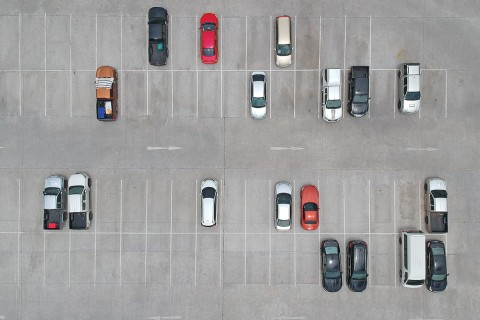

[2024-05-23 23:03:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


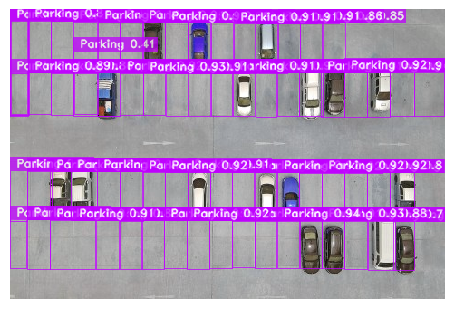

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image_choosen = "66"

image_path = f"/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/test/images/{image_choosen}.jpg"

image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"Error loading image with OpenCV: {image_path}")

cv2_imshow(image)

predictions = best_model.predict(image, conf=0.40)

predictions.show()


In [ ]:

# Paths
output_text_path = f"/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/train/labels/{image_choosen}.txt"
image_path = f"/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/valid/images/{image_choosen}.PNG"
new_image_path = f"/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/Data/datasets/train/images/{image_choosen}.PNG"

# Read the image to get its dimensions
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"Error loading image with OpenCV: {image_path}")

height, width = image.shape[:2]



# Perform detection
results = predictions

# Convert bounding boxes to YOLO format and save
with open(output_text_path, 'w') as f:
    for det in results.xyxy[0]:  # xyxy format: [x1, y1, x2, y2, confidence, class]
        x1, y1, x2, y2, conf, cls = det.tolist()

        # Convert to YOLO format
        x_center = (x1 + x2) / 2 / width
        y_center = (y1 + y2) / 2 / height
        bbox_width = (x2 - x1) / width
        bbox_height = (y2 - y1) / height

        # Write to file
        f.write(f'{int(cls)} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n')

print(f"Bounding box coordinates saved to {output_text_path}")

# Save the image in the new path
cv2.imwrite(new_image_path, image)
print(f"Image saved to {new_image_path}")

# Remove the original image
os.remove(image_path)
print(f"Deleted original image at {image_path}")


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):
/root/.cache/torch/hub/ultralytics

requirements: Ultralytics requirements ['gitpython>=3.1.30', 'numpy>=1.23.5'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 243.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0

requirements: AutoUpdate success ✅ 13.8s, installed 2 packages: ['gitpython>=3.1.30', 'numpy>=1.23.5']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-5-22 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 107MB/s] 

Fusing layers... 


In [ ]:
with open(file_path, 'w') as file:
    file.writelines(final_lines)

print(f"Bounding box coordinates have been filtered for size, overlap, and small dimensions, and the file has been updated at {file_path}")

Bounding box coordinates have been filtered for size, overlap, and small dimensions, and the file has been updated at /content/drive/MyDrive/Colab Notebooks/Data/datasets/train/labels/73.txt
